In [66]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import sys

import numpy as np
import scipy as sp
import h5py as h5

import csi.gp as gp

import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
class csi_mod(object):
    def __init__(self, hdf5path):
        self.fd = h5.File(hdf5path)

        self.data  = [d[:] for _,d in self.fd['data'].items()]
        self.items = [s.decode('utf8') for s in self.fd['items']]
        self.time  = [d.attrs["time"] for _,d in self.fd['data'].items()]
        
mod  = csi_mod("./dream-trunc3.h5")

In [20]:
class csi_res(object):
    def __init__(self, mod, res):
        self.mod = mod
        self.res = mod.fd[str(res)]
        
        self.hypers = self.res.attrs['hyperparams']
        self.target = self.res.attrs['item'][0]
        
        ll = self.res["loglik"][:]
        ii = np.argsort(-ll)
        
        self.ll      = ll[ii]
        self.psets   = [a.tolist() for a in self.res['parents'][:][ii]]
        self.weights = self.res['weight'][:][ii]

res  = [csi_res(mod,i+1) for i in range(10)]

In [46]:
[r.hypers for r in res]

[array([ 0.08919142,  0.70661467,  0.00549029]),
 array([ 0.28587201,  2.41633069,  0.00575149]),
 array([ 0.09643277,  0.47714966,  0.00431525]),
 array([ 0.11861617,  0.58956605,  0.00269323]),
 array([ 0.09212661,  0.36409201,  0.00210728]),
 array([ 0.1205697 ,  0.42939695,  0.00393759]),
 array([ 0.1306264 ,  0.42118833,  0.00146173]),
 array([ 0.06457188,  0.65415407,  0.00629374]),
 array([ 0.16529779,  0.62987784,  0.0070579 ]),
 array([ 0.19610628,  0.84285625,  0.01687024])]

In [42]:
class csi_pred(object):
    def __init__(self, res, pset, datasets):
        self.target = res.target
        self.hypers = res.hypers
        self.pset   = pset
        self.ix     = [self.target]+self.pset
        self.iy     = [self.target]
        
        X = [] # parent array
        Y = [] # target array
        for d in datasets:
            X.append(d[self.ix,:-1])
            Y.append(d[self.iy,1:])
        X = np.hstack(X).T
        Y = np.hstack(Y).T
        self.gp = gp.rbf(X,Y,self.hypers)

    def predict1(self, expr):
        return self.gp.predict(expr[None,self.ix])

dataset = 2
ds = [d for i,d in enumerate(mod.data)]
pred = [csi_pred(r,r.psets[0],ds) for r in res]

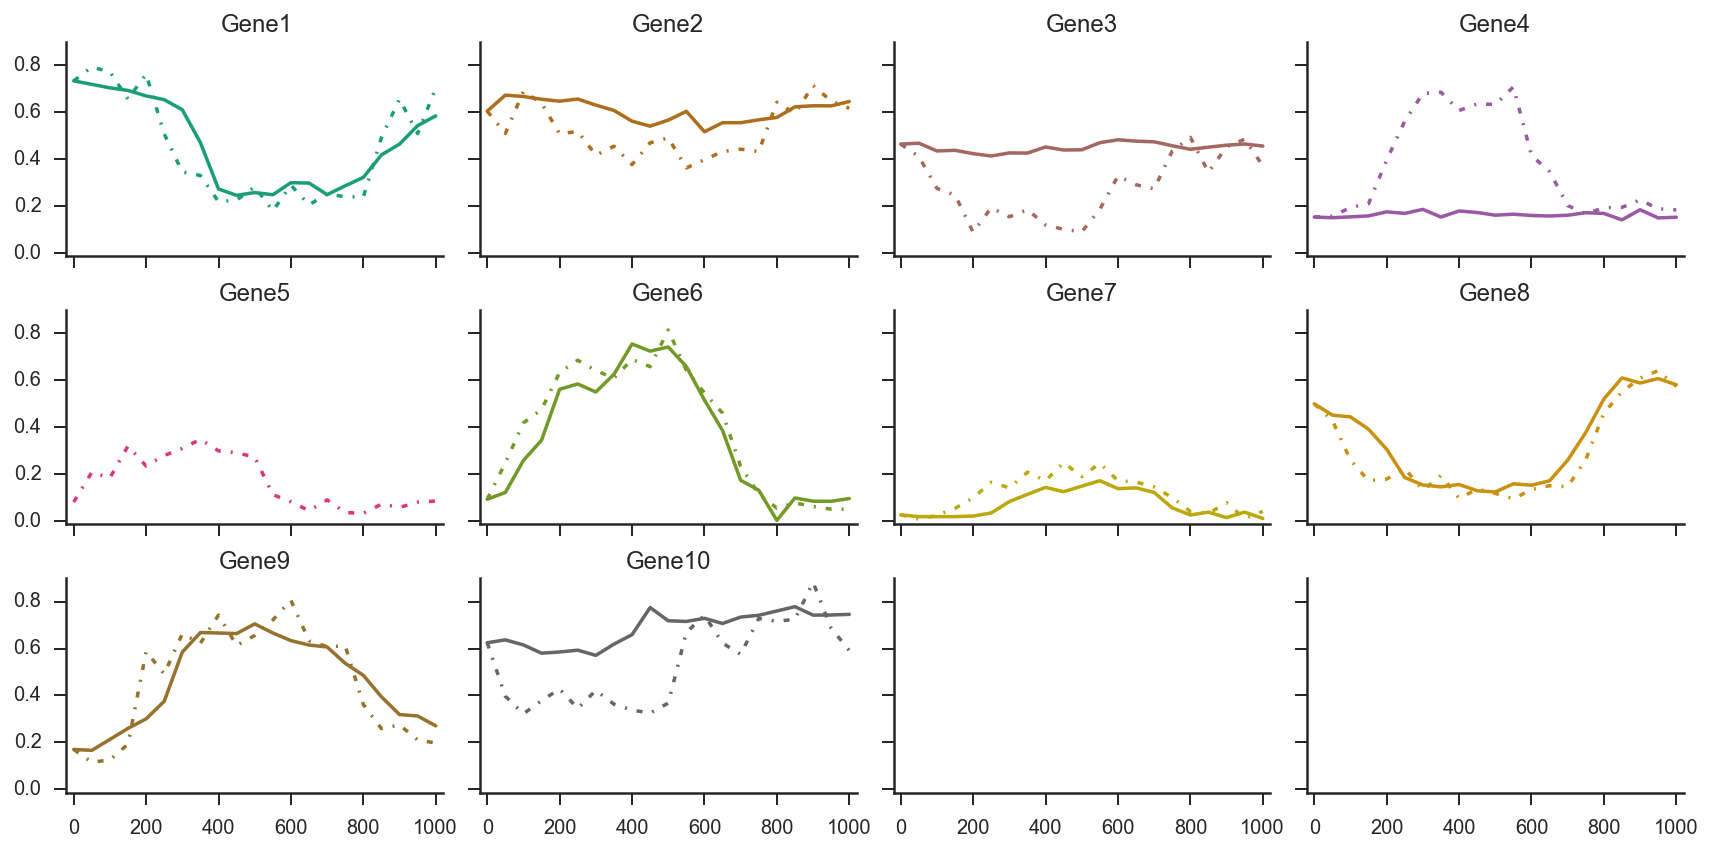

In [100]:
# 4 and 9 difficult
given = [4]

# generate predicted expression
out = sp.rand(21,10)
out[:,given] = mod.data[dataset].T[:,given]
out[0,:] = mod.data[dataset].T[0,:]
for i in range(1,len(out)):
        for j in range(10):
            if j in given:
                continue
            mu,var = pred[j].predict1(out[i-1,:])
            out[i,j] = mu[0] + sp.randn() * np.sqrt(var[0,0])

# and plot
with sns.axes_style("ticks"):
    fig,axs = plt.subplots(3,4,figsize=(12,6),sharex=True,sharey=True)

pal = plt.get_cmap('Dark2')(np.linspace(0,1,10))

for i,ax in zip(range(10),axs.flatten()):
    ax.margins(0.02)
    ax.set_title(mod.items[i])
    if i not in given:
        ax.plot(mod.time[dataset],out[:,i],color=pal[i])
    ax.plot(mod.time[dataset], mod.data[dataset].T[:,i],'-.',color=pal[i]);

sns.despine()
fig.tight_layout()